# Signal Generation

- Generate parameter distributions from bilby priors
- Sample from bilby prior distributions
- create waveform generator given a sample of parameters (fix min_freq=20Hz)
- get signal in the time-domain

In [17]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
bilby.__version__

'1.0.2: release'

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [9]:
priors = bilby.gw.prior.BBHPriorDict()

priors['mass_1'] = bilby.core.prior.PowerLaw(minimum=10, maximum=95, alpha=-1)
priors['mass_2'] = bilby.core.prior.PowerLaw(minimum=5, maximum=95, alpha=-1)
priors['a_1'] = 0  # Magnitude of spin 1 vector
priors['a_2'] = 0  # Magnitude of spin 2 vector
priors['tilt_1'] = 0  # Angle between spin 1 and newtonian orbital angular momentum L 
priors['tilt_2'] = 0  # Angle between spin 2 and newtonian orbital angular momentum L
priors['phi_12'] = 0
priors['phi_jl'] = 0 
priors['theta_jl'] = 0  # Angle between total angular momentum J and L
priors['mass_ratio'] = bilby.core.prior.Constraint(minimum=1/18, maximum=1)
priors['chirp_mass'] = bilby.core.prior.Constraint(minimum=3, maximum=85)
central_time = 0.85
priors['geocent_time']= bilby.core.prior.Uniform(central_time-0.1, central_time+0.1)

In [3]:
count = 0
N = 100
for i in range(N):
    injection_parameters = priors.sample()
    if injection_parameters["mass_1"] >= injection_parameters["mass_2"]:
        count += 1

print(count/N)

1.0


In [69]:
injection_params_set = priors.sample(N)
islarger = (injection_params_set["mass_1"] >= injection_params_set["mass_2"])
islarger_ratio = np.count_nonzero(islarger) / N
print(islarger_ratio)

1.0


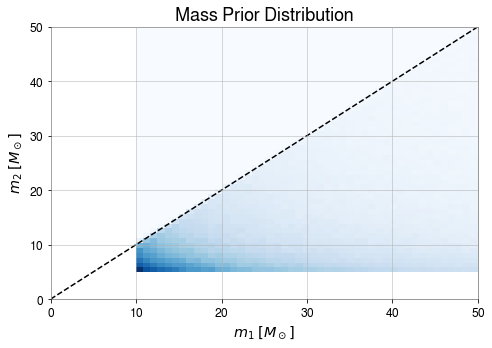

In [28]:
import matplotlib.pyplot as plt
m_max = 50
samples = priors.sample(1000000)
plt.figure(figsize=(7,5))
plt.hist2d(samples['mass_1'], samples['mass_2'], bins=100, cmap='Blues')
plt.plot(np.linspace(0,m_max), np.linspace(0,m_max),'k--')
plt.title("Mass Prior Distribution", fontsize=18)
plt.xlabel('$m_1 \;[M_\odot]$ ')
plt.ylabel('$m_2\;[M_\odot]$')
plt.xlim(0, m_max)
plt.ylim(0, m_max)
plt.tight_layout()
plt.savefig("mass_prior.png")
plt.show()

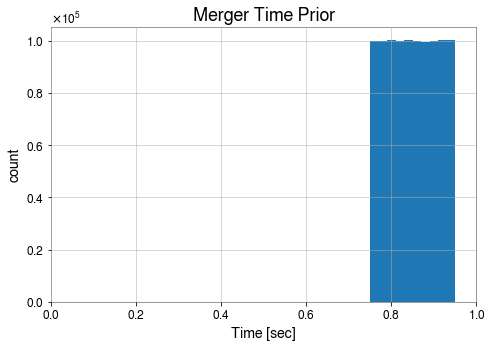

In [31]:
import matplotlib.pyplot as plt

samples = priors.sample(1000000)
plt.figure(figsize=(7,5))
plt.hist(samples['geocent_time'], bins=10)
plt.title('Merger Time Prior', fontsize=18)
plt.xlabel('Time [sec]')
plt.ylabel('count')
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("geocent_time_prior.png")
plt.show()

42.187298297600016 6.077198243076808


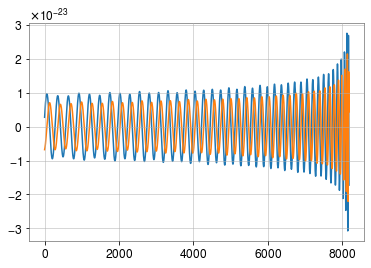

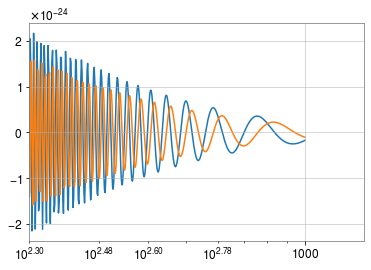

In [37]:
injection_parameters = priors.sample()
print(injection_parameters["mass_1"] , injection_parameters["mass_2"])

duration_gener = 10
duration_data = 1
sampling_frequency = 8192
minimum_frequency = 20

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., 
                          minimum_frequency=minimum_frequency, 
                          maximum_frequency=2048.)
def get_waveform(duration, sampling_frequency, 
                 injection_parameters, waveform_arguments):

    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameters=injection_parameters, waveform_arguments=waveform_arguments)
    hf_signal = waveform_generator.frequency_domain_strain(injection_parameters)
    
    ht_signal = waveform_generator.time_domain_strain(injection_parameters)
    return waveform_generator, hf_signal, ht_signal

def plot_polarizations(hf_signal, ht_signal):
    idx_min = -duration_data*sampling_frequency
    plt.plot(ht_signal["plus"].real[idx_min:]);
    plt.plot(ht_signal["cross"].real[idx_min:]);
    
    plt.figure()
    idx_max = 1000
    plt.plot(hf_signal["plus"].real[:idx_max])
    plt.plot(hf_signal["cross"].real[:idx_max])
    plt.xscale("log")
    plt.xlim(duration_gener*minimum_frequency,None)
    
waveform_generator, hf_signal, ht_signal = get_waveform(duration_gener, sampling_frequency, 
                                                 injection_parameters, waveform_arguments)
plot_polarizations(hf_signal=hf_signal, ht_signal=ht_signal)

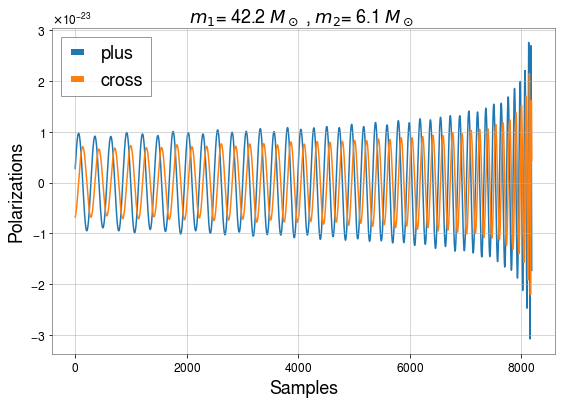

In [46]:
idx_min = -duration_data*sampling_frequency
plt.figure(figsize=(9,6))
plt.plot(ht_signal["plus"].real[idx_min:], label="plus");
plt.plot(ht_signal["cross"].real[idx_min:], label="cross");
plt.title(r"$m_1$= {} $M_\odot$ , $m_2$= {} $M_\odot$ ".format(round(injection_parameters["mass_1"],1) , 
                                        round(injection_parameters["mass_2"],1)), fontsize=18)
plt.xlabel("Samples", fontsize=18)
plt.ylabel("Polarizations", fontsize=18)
plt.legend(fontsize=18);
plt.savefig("polarizations.png");


# plt.figure()
# idx_max = 1000
# plt.plot(hf_signal["plus"].real[:idx_max])
# plt.plot(hf_signal["cross"].real[:idx_max])
# plt.xscale("log")
# plt.xlim(duration_gener*minimum_frequency,None)


In [47]:
H1 = bilby.gw.detector.get_empty_interferometer('H1')
L1 = bilby.gw.detector.get_empty_interferometer('L1')
print(H1)
print(L1)

Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)
Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=30.562894333333332, longitude=-90.77424038888887, elevation=-6.574, xarm_azimuth=197.7165, yarm_azimuth=287.7165, xarm_tilt=0.0, yarm_tilt=0.0)


In [48]:
# H1.set_strain_data_from_power_spectral_density(sampling_frequency, duration, start_time=0)
H1.set_strain_data_from_zero_noise(sampling_frequency, duration_gener, start_time=0)
ts_noise = H1.strain_data.to_gwpy_timeseries().copy()
# ts_noise.plot();

In [49]:
polarizations = H1.inject_signal_from_waveform_generator(injection_parameters, waveform_generator)
len(polarizations["plus"])

40961

40961
7.280204200241758e-25


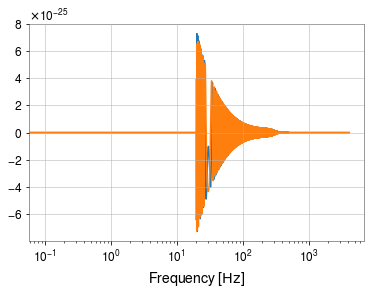

In [50]:
fd = H1.strain_data.to_gwpy_frequencyseries().copy()
print(len(fd.real))
print(np.max(fd.real))
from gwpy.plot import Plot
Plot(fd.real, fd.imag);
plt.xscale("log")

8192


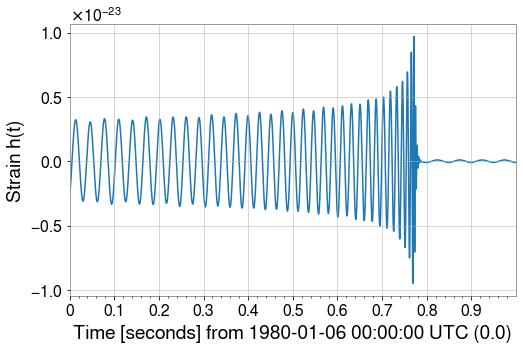

In [60]:
plt.rcParams.update({'font.size': 16})
ts = H1.strain_data.to_gwpy_timeseries().copy()
print(len(ts[:duration_data*sampling_frequency]))
ts[:duration_data*sampling_frequency].plot(figsize=(8,5));
plt.ylabel("Strain h(t)");
plt.savefig("detector_response.png");

40961
8192


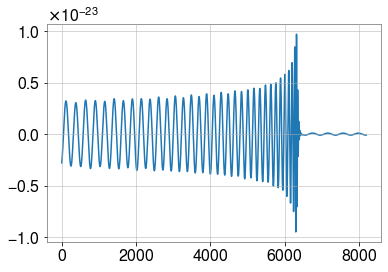

In [61]:
signal_ifo = H1.get_detector_response(hf_signal, injection_parameters)
print(len(signal_ifo))
from scipy.fft import irfft
from scipy.fft import rfft
td_signal = sampling_frequency*irfft(signal_ifo)
td_signal_cropped = td_signal[:duration_data*sampling_frequency].copy()
print(len(td_signal_cropped))
plt.plot(td_signal_cropped);

In [62]:
rho_opt = np.sqrt(H1.optimal_snr_squared(signal=signal_ifo)).real
rho_opt

0.6886449044538497

The optimal SNR is:

$$\rho_{opt} = \sqrt{4\int_{f_{min}}^{f_{max}}\frac{\tilde{h}(f)^2}{S_n(f)}}$$

Equivalently we can multiply both sides by the desired SNR $\rho_{new}$ and rearrange to get:

$$\rho_{new} = \sqrt{4\int_{f_{min}}^{f_{max}}\frac{\left(\frac{\rho_{new}}{\rho_{opt}}\tilde{h}(f)\right)^2}{S_n(f)}}$$

So in order to scale the SNR to a desired value, we need to multiply the frequency domain strain by $\rho_{new}/\rho_{opt}$.

In [63]:
rho_goal = 8
signal_ifo_scaled = (rho_goal/rho_opt)*signal_ifo
rho_new = np.sqrt(H1.optimal_snr_squared(signal=signal_ifo_scaled)).real
rho_new

7.999999999999999

We then window the data with a Tukey filter ($\alpha=1/8$). We have checked (see below) that this does not affect significantly the optimal filtering SNR. This makes sense, since the toll-off time (time needed to rise) is $\alpha \cdot\mathrm{duration}\;/\;2$.

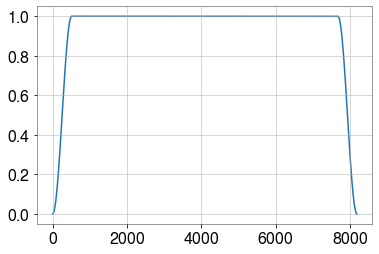

In [64]:
import scipy.signal
window_len = sampling_frequency * duration_data
dwindow = scipy.signal.tukey(window_len, alpha=1./8)
plt.plot(dwindow);

8192


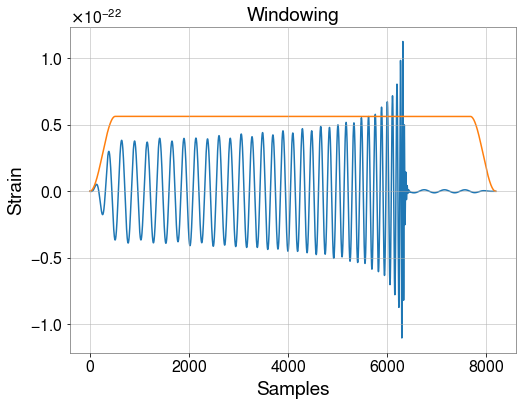

In [69]:
td_signal_scaled = sampling_frequency*irfft(signal_ifo_scaled)
td_signal_scaled_cropped = td_signal_scaled[:duration_data*sampling_frequency].copy()
ts_tuckey = dwindow*td_signal_scaled_cropped
print(len(ts_tuckey))
plt.figure(figsize=(8,6))
plt.plot(ts_tuckey);
plt.plot(dwindow* np.max(ts_tuckey)*0.5);
plt.title("Windowing")
plt.xlabel("Samples")
plt.ylabel("Strain")
plt.savefig("windowing.png")

### Check that filtering does not affect the SNR

In [22]:
td_signal_unscaled = sampling_frequency*irfft(signal_ifo)
td_signal_unscaled_cropped = td_signal_unscaled[:duration_data*sampling_frequency]
ts_tuckey_unscaled = dwindow*td_signal_unscaled_cropped
fd_tuckey_unscaled = rfft(ts_tuckey_unscaled)/sampling_frequency
len(fd_tuckey_unscaled)

4097

In [23]:
rho_opt_tukey = np.sqrt(H1.optimal_snr_squared(signal=fd_tuckey_unscaled)).real
rho_opt_tukey

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4097 but corresponding boolean dimension is 40961

In [30]:
rho_opt - rho_opt_tukey

-1.0575552822467138e-05

## Whitening the strain data

Whitening the signal

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


0.5686104185299652


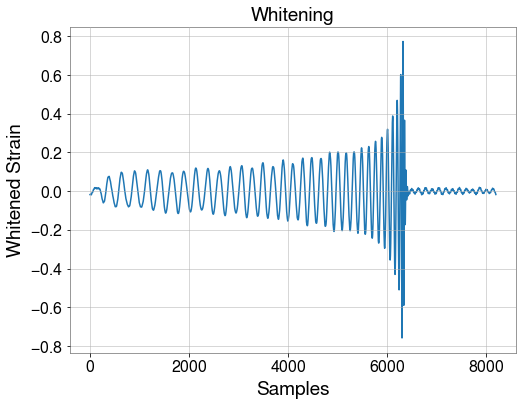

In [71]:
H1_new = bilby.gw.detector.get_empty_interferometer('H1')
H1_new.set_strain_data_from_power_spectral_density(sampling_frequency, duration_data, start_time=0)
asd = H1_new.amplitude_spectral_density_array.copy()
fd_tuckey = rfft(ts_tuckey)/sampling_frequency
fd_whiten = fd_tuckey / asd
print(np.max(fd_whiten.real))
ts_whiten = np.sqrt(sampling_frequency)*irfft(fd_whiten)
## we are multiplying by two the whitened noise timeseries, 
## so for consistency we multiply also the signal by a factor of two
ts_whiten= 2*ts_whiten
plt.figure(figsize=(8,6))
plt.plot(ts_whiten);
plt.title("Whitening")
plt.xlabel("Samples")
plt.ylabel("Whitened Strain")
plt.savefig("whitening_signal.png")

In [84]:
# myASD = H1.amplitude_spectral_density_array.copy()
# myASD[H1.amplitude_spectral_density_array == np.inf] = 0
# myASD

In [85]:
# fd_whiten = H1.whitened_frequency_domain_strain
# print(np.max(fd_whiten.real))
# ts_whiten = np.sqrt(sampling_frequency)*irfft(fd_whiten)

# plt.plot(ts_whiten);
# plt.title("Unscaled SNR");

In [72]:
H1_new = bilby.gw.detector.get_empty_interferometer('H1')
L1_new = bilby.gw.detector.get_empty_interferometer('L1')
print(H1_new)
print(L1_new)

Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)
Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=30.562894333333332, longitude=-90.77424038888887, elevation=-6.574, xarm_azimuth=197.7165, yarm_azimuth=287.7165, xarm_tilt=0.0, yarm_tilt=0.0)


In [73]:
duration_data = 1
H1_new.set_strain_data_from_power_spectral_density(sampling_frequency, duration_data, start_time=0)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


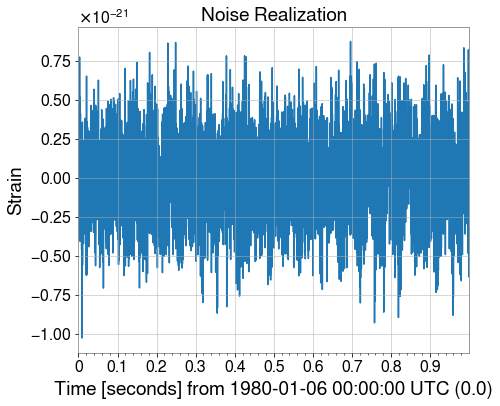

In [74]:
ts_noise_new = H1_new.strain_data.to_gwpy_timeseries().copy()
ts_noise_new.plot(figsize=(7,6));
plt.ylabel("Strain")
plt.title("Noise Realization");
plt.savefig("noise_realization.png")

0.24976395371880347
0.31201139255633936


(0.34923355901706526, 0.3574591534748674)

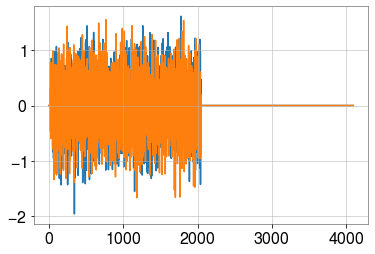

In [75]:
fd_noise_whiten = H1_new.whitened_frequency_domain_strain;
plt.plot(fd_noise_whiten.real);
plt.plot(fd_noise_whiten.imag);
psd_test = np.abs(fd_noise_whiten)**2
print(psd_test.mean())
asd_test = np.sqrt(psd_test)
print(asd_test.mean())
# for a gaussian X : E[X^2] = E[X]^2 + Var[X]
fd_noise_whiten.real.std(), fd_noise_whiten.imag.std()

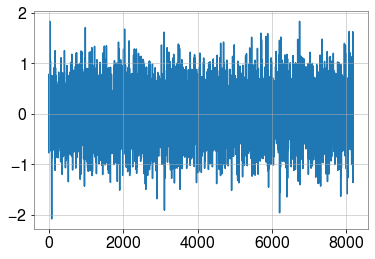

In [76]:
from bilby.core.utils import nfft, infft
ts_noise_whiten = infft(fd_noise_whiten, sampling_frequency=sampling_frequency)/np.sqrt(sampling_frequency)
plt.plot(ts_noise_whiten);

1.6140480436965075


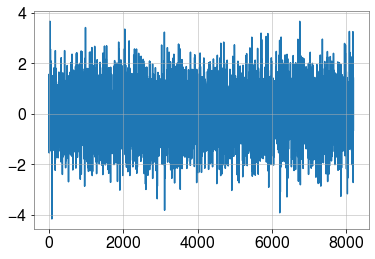

In [77]:
from scipy.fft import ifft
fd_noise_whiten = H1_new.strain_data.to_gwpy_frequencyseries().value / H1_new.amplitude_spectral_density_array.copy()
print(np.max(fd_noise_whiten.real))
ts_noise_whiten = 2*np.sqrt(sampling_frequency)*irfft(fd_noise_whiten)
plt.plot(ts_noise_whiten);

**TODO**: Histogram the noise and estimate its variance. It doesn't look to be one, so it might need rescaling. Actually, check first if the frequency_series strain data has imaginary part, because maybe then using rfft is not appropriate.

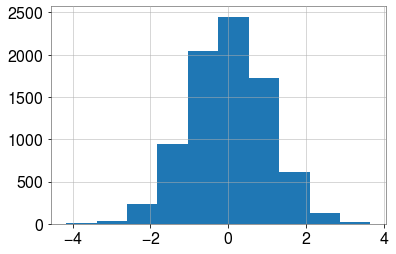

In [78]:
plt.hist(ts_noise_whiten);

In [79]:
ts_noise_whiten.mean()

-2.168404344971009e-19

In [80]:
ts_noise_whiten.std()

0.9996498011735248

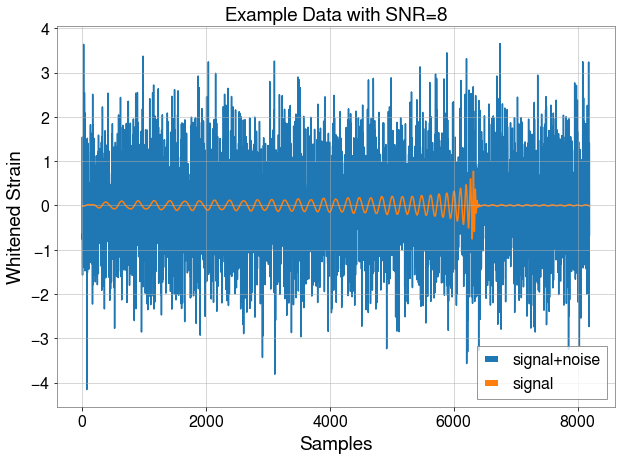

In [89]:
data = ts_whiten + ts_noise_whiten
plt.figure(figsize=(10,7))
plt.plot(data, label='signal+noise')
plt.plot(ts_whiten, label='signal')
plt.title(r"Example Data with SNR=8")
plt.xlabel("Samples")
plt.ylabel("Whitened Strain")
plt.legend(loc="lower right");
plt.savefig("example_data.png")

In [97]:
data_int16 = (data*1000).astype("int16")

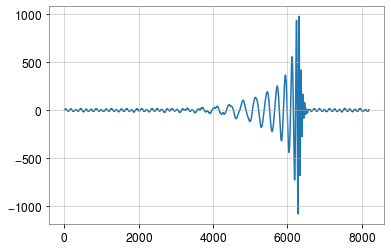

In [100]:
plt.plot(data_int16 - ts_noise_whiten*1000)

In [10]:
def get_waveform(duration, sampling_frequency, 
                 injection_parameters, waveform_arguments):

    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameters=injection_parameters, waveform_arguments=waveform_arguments)
    hf_signal = waveform_generator.frequency_domain_strain(injection_parameters)

    ht_signal = waveform_generator.time_domain_strain(injection_parameters)
    return waveform_generator, hf_signal, ht_signal

In [11]:
from scipy.fft import irfft
from scipy.fft import rfft
from scipy.fft import fft
import scipy.signal
# Specify the output directory and the name of the simulation.
outdir = 'output'
label = 'data_generation'
bilby.core.utils.setup_logger(outdir=outdir, label=label, 
                              log_level=40, print_version=True)

N_signal = 10000
N_noise_per_signal = 25
duration_gener = 10
duration_data = 1
sampling_frequency = 8192
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., minimum_frequency=20., 
                          maximum_frequency=2048.)

rho_goal = 8

def generate_signal_plus_noise_data(rho_goal, N_signal, N_noise_per_signal):

    # Generate the Tukey window
    window_len = sampling_frequency * duration_data
    dwindow = scipy.signal.tukey(window_len, alpha=1./8)
    data = np.zeros((N_signal*N_noise_per_signal, sampling_frequency*duration_data),dtype='int16')
    
    H1_whiten = bilby.gw.detector.get_empty_interferometer('H1')
    H1_whiten.set_strain_data_from_power_spectral_density(sampling_frequency, duration_data, start_time=0)
    
    for i in range(N_signal):
        injection_parameters = priors.sample()
        
        waveform_generator, hf_signal, _ = get_waveform(duration_gener, sampling_frequency, 
                     injection_parameters, waveform_arguments)
        
        # Creating an empty strain and get frequency domain response for signal
        H1 = bilby.gw.detector.get_empty_interferometer('H1')
        H1.set_strain_data_from_zero_noise(sampling_frequency, duration_gener, start_time=0)
        signal_ifo = H1.get_detector_response(hf_signal, injection_parameters)
        
        # Rescaling the time-domain
        rho_opt = np.sqrt(H1.optimal_snr_squared(signal=signal_ifo)).real
        signal_ifo_scaled = (rho_goal / rho_opt) * signal_ifo
        
        
        # Tappering the time domain signal with a Tukey Window
        td_signal_scaled = sampling_frequency * irfft(signal_ifo_scaled)
        td_signal_scaled_cropped = td_signal_scaled[:duration_data*sampling_frequency].copy()
        ts_tuckey = dwindow * td_signal_scaled_cropped
        
        # Whitening the signal and transforming back to the time domain
        fd_tuckey = rfft(ts_tuckey)/sampling_frequency
        fd_whiten = fd_tuckey / H1_whiten.amplitude_spectral_density_array
        ts_whiten = 2*np.sqrt(sampling_frequency)*irfft(fd_whiten)
        
        for j in range(N_noise_per_signal):
            # Creating a pure aLIGO design sensitivity noise timeseries
            H1_new = bilby.gw.detector.get_empty_interferometer('H1')
            H1_new.set_strain_data_from_power_spectral_density(sampling_frequency, duration_data, start_time=0)

            fd_noise_whiten = (H1_new.strain_data.to_gwpy_frequencyseries().value 
                               / H1_whiten.amplitude_spectral_density_array)
            # we multiply by 2 to get unit variance
            ts_noise_whiten = 2*np.sqrt(sampling_frequency)*irfft(fd_noise_whiten)
            
            idx = N_noise_per_signal * i + j
            datum = ts_whiten + ts_noise_whiten
            datum_int16 = (datum*1000).astype("int16")
            data[idx,:] = datum_int16
            print("\r{}".format(idx), end="")
    return data

# signal_plus_noise_data = generate_signal_plus_noise_data()
        

In [12]:
N_signal = 1000
N_noise_per_signal = 25
trials = 10
for j in range(trials):
    for snr in [4, 6, 8, 10]:
        signal_plus_noise_data = generate_signal_plus_noise_data(snr, N_signal, N_noise_per_signal)
        np.save("output/signal_plus_noise_data_rho{}_Nsig{}_x{}_int16_trial{}.npy".format(snr, N_signal, N_noise_per_signal, j), signal_plus_noise_data)

23

KeyboardInterrupt: 

In [13]:
N_pure_noise = N_signal * N_noise_per_signal
def generate_noise_data(N_pure_noise):
    
    noise_data = np.zeros((N_pure_noise, sampling_frequency*duration_data), dtype='int16')
    H1_whiten = bilby.gw.detector.get_empty_interferometer('H1')
    H1_whiten.set_strain_data_from_power_spectral_density(sampling_frequency, duration_data, start_time=0)
    for i in range(N_pure_noise):
        # Creating a pure aLIGO design sensitivity noise timeseries
        H1_new = bilby.gw.detector.get_empty_interferometer('H1')
        H1_new.set_strain_data_from_power_spectral_density(sampling_frequency, duration_data, start_time=0)

        fd_noise_whiten = (H1_new.strain_data.to_gwpy_frequencyseries().value 
                           / H1_whiten.amplitude_spectral_density_array)
        ts_noise_whiten = 2*np.sqrt(sampling_frequency)*irfft(fd_noise_whiten)
        datum = ts_noise_whiten
        datum_int16 = (datum*1000).astype("int16")
        noise_data[i,:] = datum_int16
        print("\r{}".format(i), end="")
    return noise_data

In [16]:
N_pure_noise = 25000

trials = 42
for j in range(trials):
    noise_data = generate_noise_data(N_pure_noise)
    np.save("output/noise_data_N{}_int16_trial{}.npy".format(N_pure_noise, j), noise_data)

21717

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14640

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24999

In [1]:
1+1

2